<span style="color:blue"> **Now we present material on NFA ** </span>

# Top-level functions in this module

```
This module contains the following functions that may be used in other modules to exercise concepts, compose functions, etc.
Here are the argument types

D     : DFA
N     : NFA
Q,S   : set of states
q     : state
Q0    : set of initial states
c     : character (symbol)
s     : string
Sigma : Alphabet (set)
 
Here are the functions

def is_consistent_nfa(N):
def mk_nfa(Q, Sigma, Delta, Q0, F):
def totalize_nfa(N):
def prnfa(N): 

def step_nfa(N, q, c):
def run_nfa(N, S, s, chatty=False):
def ec_step_nfa(N, S, c, chatty=False):
def accepts_nfa(N, s, chatty=False):

def nfa2dfa(N):

def rev_dfa(D): 

def min_dfa_brz(D):
```

In [1]:
# Make imports better (narrower) eventually
from Imports.ShrinkStates import shrink_dfastates
from Imports.ShrinkStates import shrink_nfastates
from Imports.ShrinkStates import mkSSnam

from Imports.Module3_DFA  import mk_dfa

from Imports.DotBashers          import *
from Imports.TransitionSelectors import *
from Imports.SystemImports       import *

The DFA are NOT language equivalent!
Path leading to counterexample is: 
[(('IF', 'IF'), ('IF', 'IF')), (('A', 'A'), ('A', 'A')), (('B', 'B'), ('B', 'B'))]


# Chapter-4: Nondeterministic Finite Automata

In this chapter, we will cover virtually all aspects of NFA, following the style of presentation used in Chapter-3 on DFA. We will sometimes be (re-) writing print (and dot-object generation) routines that look quite similar to those defined for DFA. This is because the routines are short, and we want a self-contained notebook. Besides there are subtle differences between an NFA and a DFA and it's best to make these differences manifest in dedicated routines -- than overload the former routines with extra arguments. 

<span style="color:blue"> **We begin defining NFA by providing its structure. ** </span>

We will first set up a series of definitions ending at the mk_nfa function that helps build NFA. 

Unlike with a DFA, there is no mkp_nfa function, as all NFAs are partial! (We can define a mktot_nfa function to print all moves, including unspecified moves leading to the se({}) state.)

We will define step_nfa, run_nfa and accepts_nfa which are key functions that clearly spell out how NFA differ from DFA.

We will also be defining functions for displaying NFA with the help of the _dot_ tool. The design will be similar to that with DFA.

<span style="color:blue"> **------** </span>

<span style="color:red"> __We will follow Kozen and endow an NFA with multiple start states __ </span>



This will allow the NFA to be more naturally handled. For instance, the reverse of a DFA is an NFA. When we reverse a DFA, all its final states become initial states of the NFA (that models the reversed language). There are 2 ways to handle this:

1. Introduce a fake new initial state and jump from it via $\varepsilon$ onto (what were the final state of the DFA).

2. Don't introduce the fake new initial state, but rather allow the NFA to start from all of F being really its start state.

    * Of course, in almost all situations, this is a minor difference
    
    * But to enjoy the topic as completely as one can, it is best to be "clean" and follow clean definitions.
    
        - I've seen Ed Clarke also use multiple initial states
        
        - Hence our code will be for this relaxed setup
        
        - Of course if you __REALLY__ wanted to have only one start state, then make it a singleton set of states and work that through your NFA.


<br>

__So now, following Brzozowski, we have__

<br>

An NFA is a quintuple $(Q,\Sigma,\delta,Q_0,F)$, where:

* $Q$ is a _finite nonempty_ set of states.

* $\Sigma$ is a _finite nonempty_ alphabet containing _symbols_.

* $\delta$ is a (partial)
	transition function, containing a set of _transitions_. The transitions take
    a pair from $Q\times \Sigma$ and return a __subset__ of states in $Q$. All this is succinctly
    captured by writing
    $\delta: Q\times \Sigma \rightarrow 2^Q$. 
    Here we use $2^Q$ to denote the powerset of $Q$.
    
  
* $Q_0\subseteq Q$, is __a set of initial states__.  Notice that we change from q0 (or $q_0$) which is what you find books such as Sipser and Linz using.


* $F\subseteq Q$ is a _finite_ (and _possibly empty_) set of
	final (or _accepting_) states. These are shown as double-circled nodes in the graph of a DFA. 
 
> There is no other change. I.e. $\delta$ remains the same as before.
> It is that when an NFA starts, it can find itself in a set of start states.
> Most NFAs start from a __singleton__ Q0, which is then, effectively, an NFA
 that matches most books say.

Some terminology:

> We call $Q$,$\Sigma$, $\delta$, $Q_0$, and $F$ the **_traits_** of the NFA.

> We will call an NFA **_structurally consistent_** or simply **"consistent"** if its traits pass the aforesaid checks.


Here is how the checks will be broken down:

* The supplied $\delta$ function will be checked to see if it has allowed domain and range points. 
 - The domain points must be a subset of $Q\times \Sigma$
 - The range points must be a subset of $2^Q$
  We do no insist that the supplied $\delta$ be total.
    
* $Q_0\subseteq Q$, is _the_ initial state.

* $F\subseteq Q$ is a _finite_ (and _possibly empty_) set of
	final (or _accepting_) states.  
    
We will often use the state set({}) to be the equivalent of a black-hole state for an NFA.

<span style="color:blue"> **Here is how we will represent an NFA in Python (taking a slight variant of Figure 6.1(b)'s example from the book). The variant was created by introducing a '1' edge from I to S0 also (similar to 6.1(a) -- thus showing an instance of non-determinism due to the '1' transition). Since we get features from 6.1(a) and 6.1(b), we are calling this NFA_fig61ab.

You can clearly see how the traits of the NFA are encoded. We prefer a Python dictionary, as it supports a number of convenient operations, and also one can add additional fields easily. ** </span>

In [2]:
NFA_fig61ab = { 'Q': {'I', 'S0', 'S1', 'S2', 'F'},
                'Sigma': {'0', '1'},
                'Delta': { # 
                             ('I', '0')  : {'I'},
                             ('I', '1')  : {'I', 'S0'},
                             ('I', '')   : {'S0'},
                             #
                             ('S0', '1') : {'S1'},
                             #
                             ('S1', '0') : {'S2'},
                             ('S1', '1') : {'S2'},
                             #
                             ('S2', '0') : {'F'},
                             ('S2', '1') : {'F'},
               },
                  'Q0': {'I'}, 
                  'F' : {'F'}   
                }
NFA_fig61ab

{'Delta': {('I', ''): {'S0'},
  ('I', '0'): {'I'},
  ('I', '1'): {'I', 'S0'},
  ('S0', '1'): {'S1'},
  ('S1', '0'): {'S2'},
  ('S1', '1'): {'S2'},
  ('S2', '0'): {'F'},
  ('S2', '1'): {'F'}},
 'F': {'F'},
 'Q': {'F', 'I', 'S0', 'S1', 'S2'},
 'Q0': {'I'},
 'Sigma': {'0', '1'}}

<span style="color:blue"> 
**
The extractors for the transitions contained in Delta are identical to those defined for DFA (the function definitions are repeated here to make this notebook self-contained). Notice that fn_dom and fn_range will both return a list of set of states (for a DFA it would return a list of states). The reason for returning a list is explained in the Jupyter notebook for DFA, but basically Python cannot represent a set of sets, but is OK representing a list of sets.
We will make fn_dom also to return a list (for uniformity).
** 
</span>

We now introduce consistency-checking routines. There is only one consistency checking for NFA (they are partial always).

 Consistency checker(s) for NFA have moved to DotBashers.

In [3]:
def mk_nfa(Q, Sigma, Delta, Q0, F):
    """Check for structural consistency of the given NFA traits.
       If the check passes, make and return an NFA.
    """
    newNFA = {"Q":Q, "Sigma":Sigma, "Delta":Delta, "Q0":Q0, "F":F}
    assert(
        is_consistent_nfa(newNFA)
    ), "NFA given to mk_nfa is not consistent. Plz check its components."
    return(newNFA)


In [4]:

def totalize_nfa(N):
    """In : NFA N
       Out: Totalized NFA
       Given a partially specified NFA, make it total by 
       transitioning to state set({}) wherever the incoming 
       Delta has gaps. This is done for an NFA only for things 
       like printing.
    """
    assert(
        is_consistent_nfa(N)
    ), "NFA given to totalize_nfa is not consistent."
    Sigma_w_Eps = (N["Sigma"] | {""}) # Extended Alphabet
    add_delta = { (q,c) : set({}) 
                   for q in N["Q"] 
                   for c in Sigma_w_Eps 
                   if (q,c) not in N["Delta"] }
    #
    add_delta.update(N["Delta"])
    #
    return {"Q"    : N["Q"],
            "Sigma": N["Sigma"],
            "Delta": add_delta,
            "Q0"   : N["Q0"],
            "F"    : N["F"]}

def prnfa(N):
        """Prints the NFA N neatly.
        """
        # Make the NFA total before printing
        Nt = totalize_nfa(N)
        print("")
        print("Q:",     Nt["Q"])
        print("Sigma:", Nt["Sigma"])
        print("Q0:",    Nt["Q0"])
        print("F:",     Nt["F"])
        print("Delta:")
        print("\t".join(map(str, Nt["Q"])))
        print("---------------------------------------------")
        for c in (Nt["Sigma"] | {""}):
            nxt_qs = [Nt["Delta"][(q, c)] for q in Nt["Q"]]
            print("\t".join(map(str, nxt_qs)) + "\t\t" + c)
            print("")
            
 

# Generating 'dot' graphs from NFA

<span style="color:blue"> **We can now write routines to print NFA using dot. The main routines are listed below.** </span>

* dot_nfa    : Produces a dot string for an NFA
* dotObj_nfa : Produces a dot object that can be viewed on the console 

In [5]:
# Tests of dot_nfa
NFA_fig61ab

def dot_nfa_tests():
    dot_string = dot_nfa(NFA_fig61ab)
    print(dot_string)
    
    dot_object1 = Source(dot_string)
    dot_object1 # Display it!


Q: {'I', 'S0', 'F', 'S1', 'S2'}
Sigma: {'1', '0'}
Q0: {'I'}
F: {'F'}
Delta:
I	S0	F	S1	S2
---------------------------------------------
{'I', 'S0'}	{'S1'}	set()	{'S2'}	{'F'}		1

{'I'}	set()	set()	{'S2'}	{'F'}		0

{'S0'}	set()	set()	set()	set()		



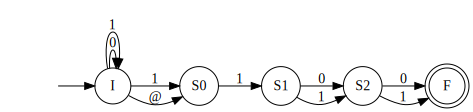

In [6]:
# Tests of dotObj_nfa
fn_range(NFA_fig61ab["Delta"])
prnfa(NFA_fig61ab)
dotObj_nfa(NFA_fig61ab,visible_eps=True,nfaName="NFA_fig61ab")

======

# Stepping and Running NFA

Now that we've defined NFA and allied actions such as consistency checking and printing, let's write functions to step and run them.

* How the state transition function $\delta$ "works"
  - captured in step_nfa

In [7]:
def step_nfa(N, q, c):
    """In : N (consistent NFA)
            q (state in N)
            c (symbol in N's sigma or "")
       Out: The set of states reached via N's Delta.
       EClosure is NOT performed.
       If the move is not defined, return {}.
    """    
    assert(
        c in (N["Sigma"] | {""})
    ), "c given to step_nfa not in Sigma."
    assert(
        q in  N["Q"]
    ), "q given to step_nfa not in Q."
    
    
    # We have to run it wrt the total version of the NFA. 
    # Since that is expensive to do each time, special-case this check.                                                               
    if (q,c) in N["Delta"].keys():
        return  N["Delta"][(q,c)]
    else:
        # If a move is undefined, it is a transition to the empty set
        return  set({})  

In [8]:
step_nfa(NFA_fig61ab, "I", "")

{'S0'}

In [9]:
step_nfa(NFA_fig61ab, "I", "0")

{'I'}

In [10]:
step_nfa(NFA_fig61ab, "I", "1")

{'I', 'S0'}

## Now we define the $\hat{\delta}$ function that runs an NFA on a string

* This is captured in run_nfa
  
     * This is more elaborate than with a DFA because we need to account for Epsilon moves
     * So we will define routines to compute the E-closure of a state
     
       - The set of states reachable by traversing Epsilon edges
  
* Our algorithm is this:

     * Eclose the given set of states S
         - If given string s is "", we are done (retn Eclosed set of states)
         - Else take step via s[0]; Eclose it to get S'; run s[1:] on S'

In [11]:
def run_nfa(N, S, s, chatty=False):
    """In : N (consistent NFA)
            S (SET of states S belonging to N's states)
            s (string over N's alphabet)
       Out: SET of states reached after processing s.
       Run the NFA starting with a SET of states S on string,
       with EClosure wherever necessary. Return set of states reached.
    """       
    # First EClose the given set of states S.
    S = Eclosure(N, S)
    if s=="":
        # run_nfa returns S if nothing to process
        return S
    else:
        # else one step via s[0]; return Eclosure of the resulting states
        return run_nfa(N, ec_step_nfa(N, S, s[0], chatty), s[1:], chatty)

In [12]:
def ec_step_nfa(N, S, c, chatty=False):
    """In : N (consistent NFA)
            S (EClosed set of states)
            c (character in N's alphabet; does not equal "")
       Return Eclosure of all states one "c" step away from S.                                                                     
    """
    post_c_state_sets = list(map(lambda st: step_nfa(N, st, c), S))
                                                                              
    # Take union of state sets contained in post_c_states
    # basis case set({}) added to make reduction succeed                                
    post_c_states = reduce(lambda x,y: set(x) | set(y), 
                           post_c_state_sets, 
                           set({}))
        
    # Eclose from post-c-states                                                                          
    Eclosed_post_c_states = Eclosure(N, post_c_states)
    
    # Return final set of states after second Eclosure  
    if chatty:
        print("States reached = ", Eclosed_post_c_states)
    return Eclosed_post_c_states

def Eclosure(N, S):
    """In : N (consistent NFA)
            S (set of states of NFA to be Eclosed)
       Out: Eclosure of S (set of states).
    """
    return Echelp(N, S, set({}))

def Echelp(Nfa, Allsofar, Previous):
    """In : Nfa (consistent NFA)
            Allsofar (set of states reached so far)
            Previous (set of states reached previously)                                     
       len(N["Delta"].items()) is the longest chain in the NFA;
       We will end up iterating that much. 
    """
    # Fixpoint reached; return Allsofar
    if (Allsofar == Previous):
        return Allsofar
    else:
        # When we apply step_nfa, we get state sets; 
        # form a list of those.
        post_eps_state_sets = list(map(lambda q: 
                                       step_nfa(Nfa, q, ""), 
                                       Allsofar))
        
        # Now OR-reduce 'em; basis case of set({}) 
        # added to make reduction succeed                           
        post_eps_states = reduce(lambda x, y: set(x) | set(y), 
                                 post_eps_state_sets,
                                 set({}))
            
        # Recurse till fixpoint reached
        return Echelp(Nfa      = Nfa, 
                      Allsofar = set(post_eps_states) | 
                                 set(Allsofar), 
                      Previous = Allsofar)

import ipywidgets as wdg
def run_nfa_slider(N, s, n):
    """Run NFA N from N["Q0"] (which is a set..) on substring s[0:n]
    """
    S = N["Q0"] 
    if (n > len(s)):
        n = len(s)
    print("string = ", s[0:n])
    run_nfa(N, S, s[0:n], True)
    
def run_nfa_int(N1, N2):
    """Run interactively from the given NFA .. from {q0} 
       on input string's substring
       as picked by slider.
    """
    inp = input("Please provide string: ")
    wdg.interact(run_nfa_slider, N = {'N1': N1, 'N2': N2}, 
                 s = inp, n=(0,32))

In [13]:
"aa"[0:0]

''

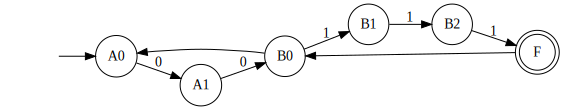

In [14]:
# NFA for ((aa)+(bbb)+)+
NFA23 = { 'Q': {'A0','A1','B0','B1','B2','F'},
          'Sigma': {'0', '1'},
          'Delta': { # 
                     ('A0', '0') : {'A1'},
                     ('A1', '0') : {'B0'},
                     #
                     ('B0', '')  : {'A0'},
                     #
                     ('B0', '1') : {'B1'},
                     ('B1', '1') : {'B2'},
                     ('B2', '1') : {'F'},
                     # 
                     ('F', '')   : {'B0'},
                   },
          'Q0': {'A0'}, 
          'F' : {'F'}   
        }
Source(dot_nfa(NFA23))

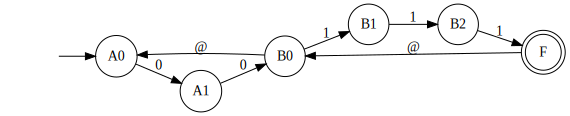

In [15]:
Source(dot_nfa(NFA23, visible_eps=True))

In [16]:
NFA23["Q0"]

{'A0'}

In [17]:
run_nfa(NFA23, NFA23["Q0"], '0', True)

States reached =  {'A1'}


{'A1'}

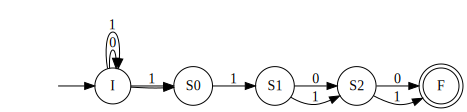

In [18]:
Source(dot_nfa(NFA_fig61ab))

In [19]:
run_nfa(NFA23, set({'A0'}), '', True)

{'A0'}

In [20]:
def test_run_nfa_int():
    """Test the interactive run of NFA.
    """
    run_nfa_int(NFA_fig61ab, NFA23) 

#-- enable this later. test_run_nfa_int()

In [21]:
Eclosure(NFA_fig61ab, {"I"})

{'I', 'S0'}

In [22]:
Eclosure(NFA_fig61ab, {"S0"})

{'S0'}

In [23]:
run_nfa(NFA_fig61ab,{"I"},"")

{'I', 'S0'}

In [24]:
run_nfa(NFA_fig61ab,{"I"},"", True)

{'I', 'S0'}

In [25]:
run_nfa(NFA_fig61ab,{"I"},"0")

{'I', 'S0'}

In [26]:
run_nfa(NFA_fig61ab,{"I"},"1")

{'I', 'S0', 'S1'}

In [27]:
run_nfa(NFA_fig61ab,{"I"},"100")

{'F', 'I', 'S0'}

In [28]:
run_nfa(NFA_fig61ab,{"I"},"100", True)

States reached =  {'S0', 'S1', 'I'}
States reached =  {'S0', 'S2', 'I'}
States reached =  {'S0', 'I', 'F'}


{'F', 'I', 'S0'}

In [29]:
run_nfa(NFA_fig61ab,{"I"},"00110")

{'F', 'I', 'S0', 'S2'}

In [30]:
run_nfa(NFA_fig61ab,{"I"},"00110", True)

States reached =  {'S0', 'I'}
States reached =  {'S0', 'I'}
States reached =  {'S0', 'S1', 'I'}
States reached =  {'S0', 'I', 'S1', 'S2'}
States reached =  {'S0', 'I', 'F', 'S2'}


{'F', 'I', 'S0', 'S2'}

### See that the NFA really runs a string, keeping its presence in all the states it must!

Now we define NFA acceptance. We provide a silent version and a chatty (verbose) version called accepts_nfav that tells you HOW the acceptance was concluded.

In [31]:
def accepts_nfa(N, s, chatty=False):
    """NFA acceptance; if chatty, print accepting path
       which is the state-sets encountered.
    """
    Q0 = N["Q0"]
    if (run_nfa(N, Q0, s, chatty) & N["F"]) != set({}):
        if chatty:
            print("NFA accepts '" + s + 
                  "' by reaching " + 
                  str(run_nfa(N, Q0, s, False)))
        return True
    else:
        if chatty:
            print("NFA rejects '" + s + "'")
        return False

In [32]:
accepts_nfa(NFA_fig61ab, "")

False

In [33]:
accepts_nfa(NFA_fig61ab, "", True)

NFA rejects ''


False

In [34]:
accepts_nfa(NFA_fig61ab, "0", True)

States reached =  {'S0', 'I'}
NFA rejects '0'


False

In [35]:
accepts_nfa(NFA_fig61ab, "100", True)

States reached =  {'S0', 'S1', 'I'}
States reached =  {'S0', 'S2', 'I'}
States reached =  {'S0', 'I', 'F'}
NFA accepts '100' by reaching {'S0', 'I', 'F'}


True

============================

 <span style="color:blue"> **Ideally one likes to have an "Recognizes a language" test also, but we don't have enough machinery to specify "a language". Well one can specify "a language" through another DFA or NFA, but then we are asking about "exactly the strings of the reference DFA D being accepted by the user-build DFA D1. I leave its implementation as an exercise, but you may wait till more material is covered, including regular expressions.** </span>

## NFA complementation

NFA complementation cannot be done by swapping final and non-final states. One may want to think of a suitable algorithm for NFA complementation (as an exercise). Solutions appear shortly.


## NFA Union, Concatenation, Star, and Reversal

These operations have straightforward implementations, and not pursued here. We will be presenting union, concatenation and star quite naturally in the context of regular expressions. Reversal will be fun to write, and will be addressed sometime soon. 

We will devote the rest of the NFA section to introduce NFA to DFA conversion (called __determinize__).

Once we achieve reversal and determinization, we can also implement Brzozowski's minimization algorithm for DFA:

* Reverse a DFA
* Determinize it
* Reverse that DFA
* Determinize it

Presto, the result will be the minimal DFA corresponding to the original!  This will also be a fun routine to write.

The proof that this construction works is given in [KamedaWeiner][KamedaWeinerNFAMin] where the authors present the proof along the way to presenting an NFA minimization algorithm. 

### The obvious question : Whither NFA Minimization?

Unfortunately, the situation with NFA minimization is "not as satisfactory as with DFA" according to [Kozen][KozenGreatBook]. For instance, minimal NFA are not necessarily unique upto isomorphism. (BTW Kozen's book is one of the amazing gems in this field, and is highly recommended.)

In one of my discussions with Prof. Alan Emerson, Turing award winner for being a co-discoverer of model checking (again using Wadler's "discovery" as opposed to "invention"; see my first book chapter), I learned the interesting fact that this is related to what prevents BDDs from being exponentially succinct always. (Curious - I should revisit on this with Emerson.)

[KozenGreatBook]: http://www.springer.com/us/book/9783642857065

[KamedaWeinerNFAMin]: http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=1671587

# NFA to DFA conversion

This is one of the most important of NFA-related operations. It will have a lot in common with running NFA where the computation of EClosure was involved in every step.



In [36]:
def nfa2dfa(N):
    """In : N (consistent NFA)
       Out: A consistent DFA that is language-equivalent to N.
    """
    assert(
        is_consistent_nfa(N)
    ), "nfa2dfa was given an inconsistent NFA."
    # EClose the starting state of the NFA
    EC = Eclosure(N, N["Q0"])
    return n2d(Frontier=[EC], Visited=[EC], Delta=dict({}), Nfa=N)

In [37]:
def n2d(Frontier, Visited, Delta, Nfa):
    """In : Frontier (list of state sets; initially Eclosed Q0)
            Visited  (list of visited state sets; initially Eclosed Q0)
            Delta    (the DFA transition function being formed)
            Nfa      (the NFA being converted)
       Helper to nfa2dfa. Given a (BFS) frontier, a Visited
       set of states, the Delta being formed, and NFA Nfa, see
       if all new moves are in Visited: 
         do last gasp of Delta update; make and return a DFA;
       else: extend Frontier, Visited, Delta; recurse.
    """
    All_c_Moves = [ ((Q,c),ec_step_nfa(Nfa,Q,c)) 
                   for Q in Frontier 
                   for c in Nfa["Sigma"] ]
    New_c_Moves = list(filter(lambda QcQ: trTrg(QcQ) not in Visited, 
                              All_c_Moves))  
    if New_c_Moves == []:
        # Add last-gasp c-moves that curl back!
        last_gasp_c_moves = dict([ ((mkSSnam(Qfrom),c),mkSSnam(Qto)) 
                                  for ((Qfrom, c), Qto) in All_c_Moves ])
        Delta.update(last_gasp_c_moves)
                  
        # DFA states are visited states
        DFA_Q = { mkSSnam(Q) for Q in Visited }
                  
        # Retain alphabet
        DFA_Sigma = Nfa["Sigma"]
                  
        # Delta is ready to go
        DFA_Delta = Delta
                  
        # DFA starts at Eclosure of Nfa's Q0 set of states
        DFA_q0 = mkSSnam(Eclosure(Nfa, Nfa["Q0"]))
                  
        # DFA's final states are those in visited that contain an NFA 
        # F-state but don't retain any empty sets, in case the NFA given 
        # has no F-states!
        # This is another corner-case (i.e. don't shove-in black hole 
        # states!)
        DFA_F = set(map(lambda Q: mkSSnam(Q), 
                        filter(lambda Q: (Nfa["F"]&Q) != set({}), 
                               Visited)))
                  
        # Make the DFA; send it to the DFA-shrink to bask ugly long 
        # state names...
        return shrink_dfastates(mk_dfa(DFA_Q, 
                                       DFA_Sigma, 
                                       DFA_Delta, 
                                       DFA_q0, 
                                       DFA_F))
    else:
        newFrontier = list(map(lambda QcQ: trTrg(QcQ), New_c_Moves)) 
        newVisited = Visited + newFrontier
                  
        # Even though the NFA has not closed back on itself, we MUST 
        # accommodate for the "curl-backs" along the way !!  Thus, run it
        # over All_c_Moves which may include "partial revisits along the 
        # way". We MUST pick up those curl-backs!
        NewMovesDelta = dict([ ((mkSSnam(Qfrom),c),mkSSnam(Qto)) 
                              for ((Qfrom, c), Qto) in All_c_Moves ]) 
        Delta.update(NewMovesDelta)
        return n2d(newFrontier, newVisited, Delta, Nfa)
                                  
#---NFA to DFA

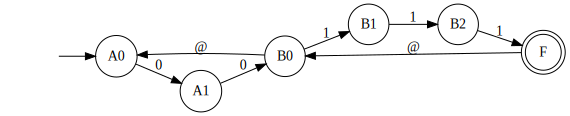

In [38]:
dotObj_nfa(NFA23, visible_eps=True, nfaName="NFA23")

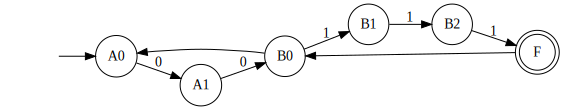

In [39]:
dotObj_nfa(NFA23, visible_eps=False, nfaName="NFA23")

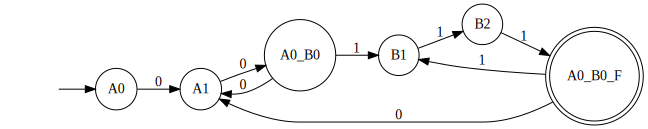

In [40]:
n2DFA23 = nfa2dfa(NFA23)
dotObj_dfa(n2DFA23, "n2dNFA23")

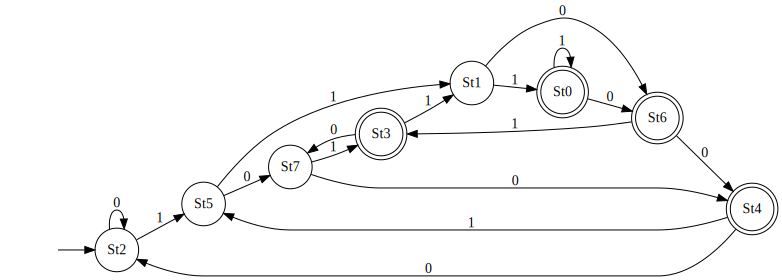

In [41]:
n2DFA61 = nfa2dfa(NFA_fig61ab)
dotObj_dfa(n2DFA61, "n2dNFA_fig61ab")

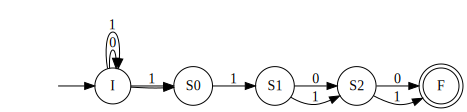

In [42]:
dotObj_nfa(NFA_fig61ab,visible_eps=False,nfaName="NFA_fig61ab")

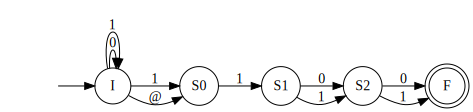

In [43]:
dotObj_nfa(NFA_fig61ab,visible_eps=True,nfaName="NFA_fig61ab")

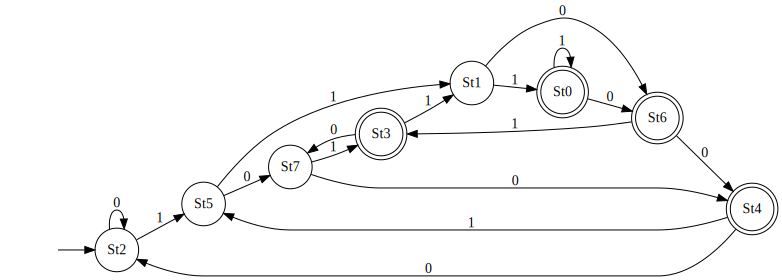

In [44]:
dotObj_dfa(nfa2dfa(NFA_fig61ab), 'n1')

# Brzozowski's DFA Minimization

Picking up from our earlier discussions, to minimize a DFA using Brzozowski's algorithm, here are the steps:

* Make sure that the given DFA has no unreachable states
* Reverse the DFA
* Determinize it
* Reverse that DFA
* Determinize it

Thus we need to write a routine to reverse a DFA. We already have a way to ensure that a DFA does not have unreachable states (in another Jupyter notebook; we won't bother to include it here, and trust the user to always provide such DFA only).

We can observe that if a DFA has black-hole states, then those states won't matter in the reversed machine (reversed NFA). Thus, we can work with __partial__ dfa (i.e., DFA that are partially consistent).

## DFA reversal

In [45]:
def inSets(D,trg,ch):
    """In : D   = partially consistent dfa,
            trg = a target state in D["q"]
            ch  = a member of D["Sigma"]
       Out: a set of states. { q s.t. Delta[q,ch] == trg }
    """
    return { q for q in D["Q"] if D["Delta"][(q,ch)] == trg }

def rev_dfa(D):
    """In : D = a partially consistent DFA without any unreachable states.
       Out: A consistent NFA whose language is D's language reversed.
    """
    # 1. Given that NFAs start from a SET of states, we already have that
    #   info. No need to add any transitions from "a new initial state" 
    #   etc
    
    # 2. Now add the inSets of each state as the NFA next set of states
    NDict = { (q,ch) : inSets(D,q,ch) 
              for q in D["Q"] 
              for ch in D["Sigma"] }
    
    # Notice that we retain D["Q"] and start from Q0 = D["F"]
    # going backwards along NDict toward F_dfa = { D["q0"] }
    return mk_nfa(D["Q"], D["Sigma"], NDict, D["F"], {D["q0"]})

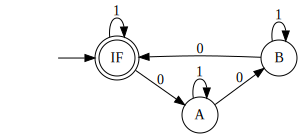

In [46]:
DFA34 = { 'Q': {'A', 'IF', 'B'},
          'Sigma': {'0', '1'},
          'Delta': { ('IF', '0'): 'A',
                     ('IF', '1'): 'IF',
                     ('A', '0'): 'B',
                     ('A', '1'): 'A',
                     ('B', '0'): 'IF',
                     ('B', '1'): 'B' },
          'q0': 'IF', 
          'F': {'IF'}   
        }
dotObj_dfa(DFA34, "DFA34")

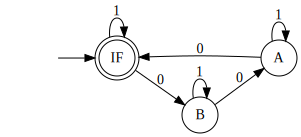

In [47]:
DFA34_rev = rev_dfa(DFA34)
dotObj_nfa(DFA34_rev, "DFA34_rev")

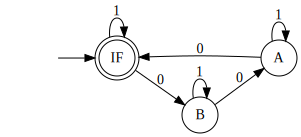

In [48]:
DFA34_rev_det = nfa2dfa(DFA34_rev)
dotObj_dfa(DFA34_rev_det, "DFA34_rev_det")

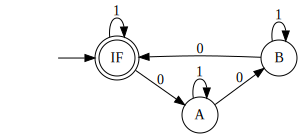

In [49]:
DFA34_rev_det_rev = rev_dfa(DFA34_rev_det)
dotObj_nfa(DFA34_rev_det_rev, "DFA34_rev_det_rev")

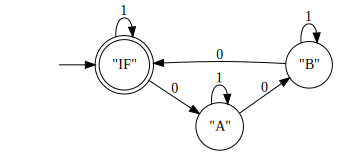

In [50]:
DFA34_rev_det_rev_det = nfa2dfa(DFA34_rev_det_rev)
dotObj_dfa(DFA34_rev_det_rev_det, "DFA34_rev_det_rev_det")

__TRY NEW EXAMPLE HERE__

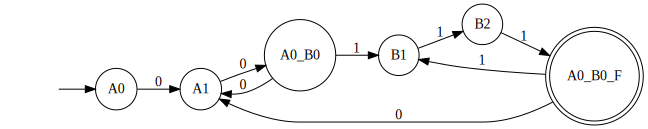

In [51]:
dotObj_dfa(n2DFA23, "n2DFA23")

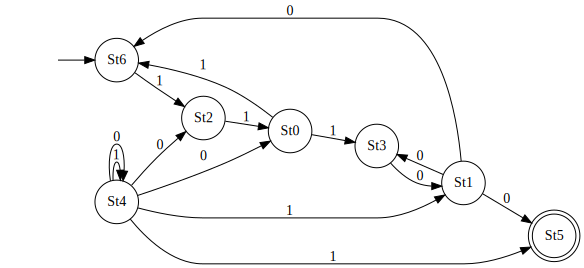

In [52]:
rev_n2DFA23 = rev_dfa(n2DFA23)
dotObj_nfa(rev_n2DFA23, "rev23")

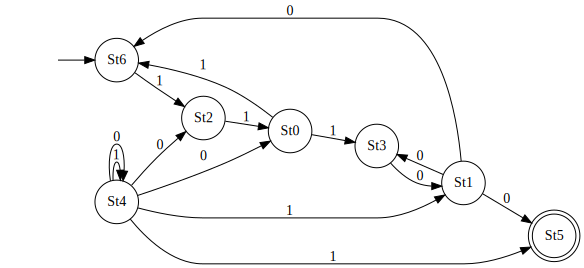

In [53]:
det_rev_n2DFA23 = nfa2dfa(rev_dfa(n2DFA23))
dotObj_nfa(rev_n2DFA23, "rev23")

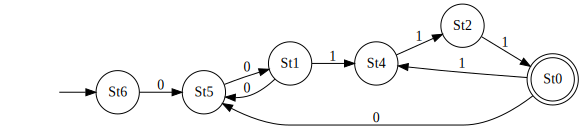

In [54]:
n2DFA23
dotObj_dfa(nfa2dfa(rev_dfa(nfa2dfa(rev_dfa(n2DFA23)))), "rdrd")

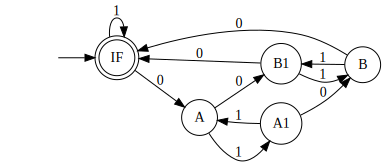

In [55]:
D34bl = { 'Q': {'A', 'IF', 'B', 'A1', 'B1'},
          'Sigma': {'0', '1'},
          'Delta': { ('IF', '0'): 'A',
                     ('IF', '1'): 'IF',
                     ('A', '0'): 'B1',
                     ('A', '1'): 'A1',
                     ('A1', '0'): 'B',
                     ('A1', '1'): 'A',
                     ('B1', '0'): 'IF',
                     ('B1', '1'): 'B',
                     ('B','0') : 'IF',
                     ('B', '1'): 'B1' },
          'q0': 'IF', 
          'F': {'IF'}   
        }

dotObj_dfa(D34bl, "D34bl")

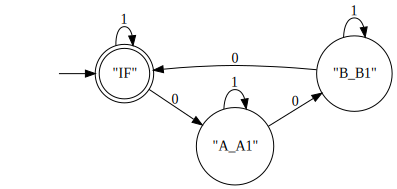

In [56]:
dotObj_dfa(nfa2dfa(rev_dfa(nfa2dfa(rev_dfa(D34bl)))), "D34bl_rdrd")

In [57]:
def min_dfa_brz(D):
    """Minimize a DFA as per Brzozowski's algorithm.
    """
    return nfa2dfa(rev_dfa(nfa2dfa(rev_dfa(D))))

# Conclusions

This notebook covered the basics of NFA including

* (Summarize)
 
(Add more concluding remarks)